In [1]:
# Import Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas as pd
import sklearn
import cPickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 

In [2]:
#Check data,  data has lots of empty spaces/tabs (\t), np.loadtxt won't read it.
sms=open('smss') # Corpus od sms stored in file 'smss' 
sms.read(180)

'ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...\nham\tOk lar... Joking wif u oni...\nspam\tFree entry in 2 a wkly co'

In [3]:
# Separate lines, strip off by '\n'
sms_clean=[x.strip() for x in open('smss')] # for x in sms gives different result for some reason.
#print sms_clean

In [4]:
# Load in panda datframe
sms=pd.read_csv('smss',sep='\t',names=['label','sms_txt'])
sms.head(3)

,label,sms_txt
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [5]:
# Check panda dataframe
print sms.shape[0], sms.shape[1], len(sms.columns), len(sms.index), sms.shape

5572 2 2 5572 (5572, 2)


In [6]:
# Get some staistica
sms.groupby('label').describe()

sms_txt
label                                                          
ham   count                                                4825
      unique                                               4516
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4

In [7]:
# Add text length column in existing dataframe
sms['txt_length']=sms['sms_txt'].map(lambda x: len(x))
sms.head(3)

,label,sms_txt,txt_length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155


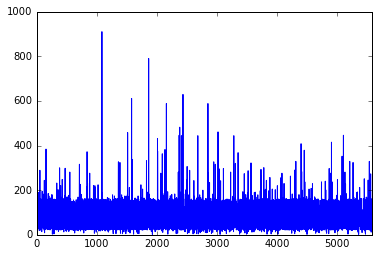

In [8]:
# SMS length visualization
sms.txt_length.plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd988699050>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fd95581b6d0>], dtype=object)

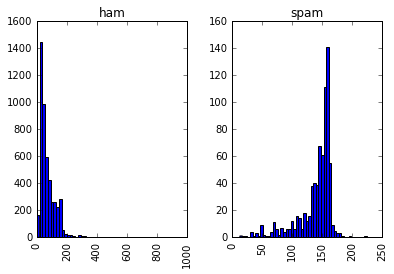

In [9]:
# Text length cisualization by label
sms.hist(column='txt_length', by='label',bins=50)

In [10]:
# Longest and shortest sms
print sms.txt_length[sms.txt_length>900], sms.txt_length[sms.txt_length<3]

1085    910
Name: txt_length, dtype: int64 1925    2
3051    2
4498    2
5357    2
Name: txt_length, dtype: int64


In [11]:
# Statistics of text length
sms.txt_length.describe()

count    5572.000000
mean       80.616296
std        60.015593
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: txt_length, dtype: float64

In [12]:
# tokenize and identify words using textblob
def tokenize(txt):
    txt=unicode(txt,'utf8')
    return TextBlob(txt).words
sms.sms_txt.apply(tokenize).head(3)

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
Name: sms_txt, dtype: object

In [13]:
# Lemmentization
def lemmentization(txt):
    txt=unicode(txt, 'utf8').lower()
    words=TextBlob(txt).words
    return [x.lemma for x in words]
sms.sms_txt.apply(lemmentization).head(3)

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
Name: sms_txt, dtype: object

In [14]:
# Create vocab
vocab=CountVectorizer(analyzer=lemmentization).fit(sms['sms_txt'])
len(vocab.vocabulary_)

8874

In [15]:
# Get corpus vector
vector=vocab.transform(sms['sms_txt'])
print vector.shape

(5572, 8874)


In [17]:
# Get tfidf of document/corpus
tfidf_transformer=TfidfTransformer().fit(vector)
tfidf=tfidf_transformer.transform(vector)
tfidf.shape

(5572, 8874)

In [18]:
# Use NB calssifier; training testing on whole data.
spam_detector=MultinomialNB().fit(tfidf, sms['label'])
sms_prediction=spam_detector.predict(tfidf)
print sms_prediction, '\n'
# accuracy check
print accuracy_score(sms['label'],sms_prediction)

['ham' 'ham' 'spam' ..., 'ham' 'ham' 'ham'] 

0.969490308686


In [19]:
# Now check NB calissfier by splitting  training and testing data.
msg_train, msg_test, label_train, label_test = train_test_split(sms['sms_txt'],sms['label'],test_size=0.2)
print len(msg_train), len(msg_test)

4457 1115


In [20]:
# Use pipeline to transform and predict, can be done in separate steps w/o pipeline as well.
pipeline=Pipeline([('vector',CountVectorizer(analyzer=lemmentization)),('tfidf', TfidfTransformer()),('classifier',MultinomialNB())])

In [21]:
# Lets check score
scores=cross_val_score(pipeline, msg_train, label_train,cv=10, scoring='accuracy', n_jobs=-1)
print scores

[ 0.94618834  0.9573991   0.95964126  0.93273543  0.94843049  0.9529148
  0.93273543  0.94843049  0.95955056  0.95720721]
